In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(540704, 828)
(540704, 1)
validation
(80437, 828)
(80437, 1)
test
(63506, 828)
(63506, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/55 [..............................] - ETA: 1:08 - loss: 0.0140 - STD: 8.9912e-05 - MAE: 0.0637

 4/55 [=>............................] - ETA: 1s - loss: 0.0207 - STD: 2.9881e-04 - MAE: 0.1025  

 5/55 [=>............................] - ETA: 1s - loss: 0.0214 - STD: 3.1779e-04 - MAE: 0.1037

 6/55 [==>...........................] - ETA: 2s - loss: 0.0219 - STD: 3.3705e-04 - MAE: 0.1046

 7/55 [==>...........................] - ETA: 5s - loss: 0.0219 - STD: 3.6472e-04 - MAE: 0.1038

11/55 [=====>........................] - ETA: 3s - loss: 0.0191 - STD: 5.2250e-04 - MAE: 0.0956

12/55 [=====>........................] - ETA: 3s - loss: 0.0190 - STD: 5.6070e-04 - MAE: 0.0973

13/55 [======>.......................] - ETA: 3s - loss: 0.0188 - STD: 5.9548e-04 - MAE: 0.0985

14/55 [======>.......................] - ETA: 3s - loss: 0.0185 - STD: 6.2526e-04 - MAE: 0.0985

15/55 [=======>......................] - ETA: 2s - loss: 0.0181 - STD: 6.5030e-04 - MAE: 0.0974

16/55 [=======>......................] - ETA: 2s - loss: 0.0177 - STD: 6.7047e-04 - MAE: 0.0956

17/55 [========>.....................] - ETA: 2s - loss: 0.0175 - STD: 6.8703e-04 - MAE: 0.0937

18/55 [========>.....................] - ETA: 2s - loss: 0.0173 - STD: 7.0174e-04 - MAE: 0.0920

19/55 [=========>....................] - ETA: 2s - loss: 0.0172 - STD: 7.1489e-04 - MAE: 0.0905

20/55 [=========>....................] - ETA: 2s - loss: 0.0171 - STD: 7.2818e-04 - MAE: 0.0893

21/55 [==========>...................] - ETA: 2s - loss: 0.0169 - STD: 7.4368e-04 - MAE: 0.0880

22/55 [===========>..................] - ETA: 2s - loss: 0.0168 - STD: 7.6114e-04 - MAE: 0.0869

23/55 [===========>..................] - ETA: 2s - loss: 0.0166 - STD: 7.8090e-04 - MAE: 0.0860

24/55 [============>.................] - ETA: 2s - loss: 0.0164 - STD: 8.0307e-04 - MAE: 0.0854

25/55 [============>.................] - ETA: 2s - loss: 0.0163 - STD: 8.2775e-04 - MAE: 0.0852

26/55 [=============>................] - ETA: 2s - loss: 0.0162 - STD: 8.5367e-04 - MAE: 0.0853

27/55 [=============>................] - ETA: 1s - loss: 0.0161 - STD: 8.7996e-04 - MAE: 0.0855

28/55 [==============>...............] - ETA: 1s - loss: 0.0160 - STD: 9.0692e-04 - MAE: 0.0856

29/55 [==============>...............] - ETA: 1s - loss: 0.0159 - STD: 9.3349e-04 - MAE: 0.0855

30/55 [===============>..............] - ETA: 1s - loss: 0.0158 - STD: 9.6016e-04 - MAE: 0.0852

31/55 [===============>..............] - ETA: 1s - loss: 0.0157 - STD: 9.8542e-04 - MAE: 0.0847

32/55 [================>.............] - ETA: 1s - loss: 0.0156 - STD: 0.0010 - MAE: 0.0842    

33/55 [=================>............] - ETA: 1s - loss: 0.0155 - STD: 0.0010 - MAE: 0.0836

34/55 [=================>............] - ETA: 1s - loss: 0.0154 - STD: 0.0011 - MAE: 0.0830

35/55 [==================>...........] - ETA: 1s - loss: 0.0154 - STD: 0.0011 - MAE: 0.0824

36/55 [==================>...........] - ETA: 1s - loss: 0.0153 - STD: 0.0011 - MAE: 0.0819

37/55 [===================>..........] - ETA: 1s - loss: 0.0152 - STD: 0.0012 - MAE: 0.0815

38/55 [===================>..........] - ETA: 1s - loss: 0.0152 - STD: 0.0012 - MAE: 0.0812

39/55 [====================>.........] - ETA: 1s - loss: 0.0151 - STD: 0.0012 - MAE: 0.0810

40/55 [====================>.........] - ETA: 1s - loss: 0.0150 - STD: 0.0013 - MAE: 0.0808

41/55 [=====================>........] - ETA: 0s - loss: 0.0150 - STD: 0.0013 - MAE: 0.0808

42/55 [=====================>........] - ETA: 0s - loss: 0.0149 - STD: 0.0014 - MAE: 0.0807

43/55 [======================>.......] - ETA: 0s - loss: 0.0149 - STD: 0.0014 - MAE: 0.0807

44/55 [=======================>......] - ETA: 0s - loss: 0.0148 - STD: 0.0015 - MAE: 0.0806

45/55 [=======================>......] - ETA: 0s - loss: 0.0148 - STD: 0.0015 - MAE: 0.0804

46/55 [========================>.....] - ETA: 0s - loss: 0.0147 - STD: 0.0016 - MAE: 0.0801

47/55 [========================>.....] - ETA: 0s - loss: 0.0146 - STD: 0.0016 - MAE: 0.0798

48/55 [=========================>....] - ETA: 0s - loss: 0.0146 - STD: 0.0017 - MAE: 0.0795

49/55 [=========================>....] - ETA: 0s - loss: 0.0146 - STD: 0.0018 - MAE: 0.0792

50/55 [==========================>...] - ETA: 0s - loss: 0.0145 - STD: 0.0019 - MAE: 0.0790

51/55 [==========================>...] - ETA: 0s - loss: 0.0145 - STD: 0.0020 - MAE: 0.0787

52/55 [===========================>..] - ETA: 0s - loss: 0.0144 - STD: 0.0020 - MAE: 0.0785

53/55 [===========================>..] - ETA: 0s - loss: 0.0144 - STD: 0.0022 - MAE: 0.0784

54/55 [============================>.] - ETA: 0s - loss: 0.0143 - STD: 0.0023 - MAE: 0.0783

55/55 [==============================] - ETA: 0s - loss: 0.0143 - STD: 0.0024 - MAE: 0.0782

55/55 [==============================] - 6s 79ms/step - loss: 0.0143 - STD: 0.0024 - MAE: 0.0782 - val_loss: 0.0138 - val_STD: 0.0092 - val_MAE: 0.0869


Epoch 2/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0119 - STD: 0.0101 - MAE: 0.0725

 2/55 [>.............................] - ETA: 3s - loss: 0.0117 - STD: 0.0106 - MAE: 0.0718

 3/55 [>.............................] - ETA: 3s - loss: 0.0116 - STD: 0.0111 - MAE: 0.0708

 4/55 [=>............................] - ETA: 3s - loss: 0.0115 - STD: 0.0116 - MAE: 0.0697

 5/55 [=>............................] - ETA: 3s - loss: 0.0114 - STD: 0.0122 - MAE: 0.0687

 6/55 [==>...........................] - ETA: 3s - loss: 0.0113 - STD: 0.0128 - MAE: 0.0677

 7/55 [==>...........................] - ETA: 3s - loss: 0.0112 - STD: 0.0134 - MAE: 0.0667

 8/55 [===>..........................] - ETA: 2s - loss: 0.0111 - STD: 0.0142 - MAE: 0.0662

 9/55 [===>..........................] - ETA: 2s - loss: 0.0110 - STD: 0.0151 - MAE: 0.0659

10/55 [====>.........................] - ETA: 2s - loss: 0.0109 - STD: 0.0161 - MAE: 0.0657

11/55 [=====>........................] - ETA: 2s - loss: 0.0108 - STD: 0.0172 - MAE: 0.0656

12/55 [=====>........................] - ETA: 2s - loss: 0.0107 - STD: 0.0183 - MAE: 0.0654

13/55 [======>.......................] - ETA: 2s - loss: 0.0106 - STD: 0.0195 - MAE: 0.0650

14/55 [======>.......................] - ETA: 2s - loss: 0.0104 - STD: 0.0208 - MAE: 0.0644

15/55 [=======>......................] - ETA: 2s - loss: 0.0103 - STD: 0.0221 - MAE: 0.0639

16/55 [=======>......................] - ETA: 2s - loss: 0.0101 - STD: 0.0236 - MAE: 0.0632

17/55 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 0.0251 - MAE: 0.0627

18/55 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 0.0268 - MAE: 0.0622

19/55 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0285 - MAE: 0.0618

20/55 [=========>....................] - ETA: 2s - loss: 0.0095 - STD: 0.0303 - MAE: 0.0614

21/55 [==========>...................] - ETA: 2s - loss: 0.0094 - STD: 0.0321 - MAE: 0.0610

22/55 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 0.0337 - MAE: 0.0605

23/55 [===========>..................] - ETA: 2s - loss: 0.0091 - STD: 0.0354 - MAE: 0.0601

24/55 [============>.................] - ETA: 1s - loss: 0.0090 - STD: 0.0371 - MAE: 0.0597

25/55 [============>.................] - ETA: 1s - loss: 0.0088 - STD: 0.0389 - MAE: 0.0594

26/55 [=============>................] - ETA: 1s - loss: 0.0087 - STD: 0.0405 - MAE: 0.0590

27/55 [=============>................] - ETA: 1s - loss: 0.0086 - STD: 0.0420 - MAE: 0.0586

28/55 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.0434 - MAE: 0.0582

29/55 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.0446 - MAE: 0.0578

30/55 [===============>..............] - ETA: 1s - loss: 0.0083 - STD: 0.0457 - MAE: 0.0574

31/55 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0469 - MAE: 0.0571

32/55 [================>.............] - ETA: 1s - loss: 0.0080 - STD: 0.0481 - MAE: 0.0567

33/55 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0492 - MAE: 0.0564

34/55 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0502 - MAE: 0.0560

35/55 [==================>...........] - ETA: 1s - loss: 0.0078 - STD: 0.0512 - MAE: 0.0557

36/55 [==================>...........] - ETA: 1s - loss: 0.0077 - STD: 0.0521 - MAE: 0.0554

37/55 [===================>..........] - ETA: 1s - loss: 0.0076 - STD: 0.0532 - MAE: 0.0551

38/55 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0541 - MAE: 0.0548

39/55 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0551 - MAE: 0.0545

40/55 [====================>.........] - ETA: 0s - loss: 0.0074 - STD: 0.0560 - MAE: 0.0542

41/55 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0569 - MAE: 0.0540

42/55 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0578 - MAE: 0.0537

43/55 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0586 - MAE: 0.0534

44/55 [=======================>......] - ETA: 0s - loss: 0.0071 - STD: 0.0593 - MAE: 0.0532

45/55 [=======================>......] - ETA: 0s - loss: 0.0070 - STD: 0.0601 - MAE: 0.0529

46/55 [========================>.....] - ETA: 0s - loss: 0.0070 - STD: 0.0608 - MAE: 0.0527

47/55 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0615 - MAE: 0.0525

48/55 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0622 - MAE: 0.0522

49/55 [=========================>....] - ETA: 0s - loss: 0.0068 - STD: 0.0628 - MAE: 0.0520

50/55 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0635 - MAE: 0.0517

51/55 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0641 - MAE: 0.0515

52/55 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0647 - MAE: 0.0513

54/55 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0656 - MAE: 0.0508

55/55 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0661 - MAE: 0.0506

55/55 [==============================] - 4s 67ms/step - loss: 0.0065 - STD: 0.0661 - MAE: 0.0506 - val_loss: 0.0042 - val_STD: 0.1024 - val_MAE: 0.0456


Epoch 3/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0950 - MAE: 0.0393

 2/55 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0948 - MAE: 0.0395

 3/55 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0948 - MAE: 0.0394

 4/55 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0949 - MAE: 0.0393

 5/55 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0950 - MAE: 0.0390

 6/55 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0953 - MAE: 0.0389

 7/55 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0954 - MAE: 0.0388

 8/55 [===>..........................] - ETA: 2s - loss: 0.0034 - STD: 0.0954 - MAE: 0.0387

 9/55 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0956 - MAE: 0.0385

10/55 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0961 - MAE: 0.0385

11/55 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0963 - MAE: 0.0384

12/55 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0961 - MAE: 0.0383

13/55 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0962 - MAE: 0.0382

14/55 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0965 - MAE: 0.0382

15/55 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0381

16/55 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0967 - MAE: 0.0380

17/55 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0967 - MAE: 0.0379

18/55 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0969 - MAE: 0.0379

19/55 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0378

20/55 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0377

21/55 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0971 - MAE: 0.0377

22/55 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0972 - MAE: 0.0376

23/55 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0974 - MAE: 0.0375

24/55 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0975 - MAE: 0.0375

25/55 [============>.................] - ETA: 1s - loss: 0.0032 - STD: 0.0975 - MAE: 0.0374

26/55 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0976 - MAE: 0.0373

28/55 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0976 - MAE: 0.0372

29/55 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0975 - MAE: 0.0372

30/55 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0976 - MAE: 0.0371

31/55 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0977 - MAE: 0.0371

32/55 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0978 - MAE: 0.0370

33/55 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0980 - MAE: 0.0370

34/55 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0980 - MAE: 0.0369

35/55 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0982 - MAE: 0.0369

36/55 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0983 - MAE: 0.0368

37/55 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0984 - MAE: 0.0368

38/55 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0367

39/55 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0985 - MAE: 0.0367

40/55 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0367

41/55 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0986 - MAE: 0.0366

42/55 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0366

43/55 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0365

44/55 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0365

45/55 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0987 - MAE: 0.0364

46/55 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0988 - MAE: 0.0364

47/55 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0989 - MAE: 0.0364

48/55 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0990 - MAE: 0.0364

49/55 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0990 - MAE: 0.0363

50/55 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0363

51/55 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0991 - MAE: 0.0362

52/55 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0992 - MAE: 0.0362

53/55 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0992 - MAE: 0.0362

54/55 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0992 - MAE: 0.0361

55/55 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0992 - MAE: 0.0361

55/55 [==============================] - 4s 66ms/step - loss: 0.0029 - STD: 0.0992 - MAE: 0.0361 - val_loss: 0.0031 - val_STD: 0.1084 - val_MAE: 0.0436


Epoch 4/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0981 - MAE: 0.0340

 2/55 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1016 - MAE: 0.0342

 3/55 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1009 - MAE: 0.0342

 4/55 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1006 - MAE: 0.0341

 5/55 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1018 - MAE: 0.0342

 6/55 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1013 - MAE: 0.0343

 7/55 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1019 - MAE: 0.0343

 8/55 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0343

 9/55 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0342

10/55 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0342

11/55 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0342

12/55 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.1021 - MAE: 0.0342

13/55 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1023 - MAE: 0.0342

14/55 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.1023 - MAE: 0.0342

15/55 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1021 - MAE: 0.0342

16/55 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0342

17/55 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0341

18/55 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0341

19/55 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0340

20/55 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0340

21/55 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1026 - MAE: 0.0340

22/55 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1026 - MAE: 0.0340

23/55 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0340

24/55 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0340

25/55 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0339

26/55 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0339

27/55 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.1025 - MAE: 0.0339

28/55 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0339

29/55 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0339

30/55 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0339

31/55 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0338

32/55 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0338

33/55 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0338

34/55 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0338

35/55 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0338

36/55 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1022 - MAE: 0.0338

37/55 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0338

38/55 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0337

39/55 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0337

40/55 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0337

41/55 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0337

42/55 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0337

43/55 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1021 - MAE: 0.0336

44/55 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

46/55 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

47/55 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

48/55 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0336

49/55 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0336

50/55 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0336

51/55 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0336

52/55 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0335

53/55 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0335

54/55 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0335

55/55 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0335

55/55 [==============================] - 4s 67ms/step - loss: 0.0024 - STD: 0.1020 - MAE: 0.0335 - val_loss: 0.0032 - val_STD: 0.1153 - val_MAE: 0.0425


Epoch 5/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.1047 - MAE: 0.0333

 2/55 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1062 - MAE: 0.0338

 3/55 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1019 - MAE: 0.0340

 4/55 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1019 - MAE: 0.0335

 5/55 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1034 - MAE: 0.0337

 6/55 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1020 - MAE: 0.0337

 7/55 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1021 - MAE: 0.0334

 8/55 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0337

 9/55 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0336

10/55 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.1020 - MAE: 0.0337

11/55 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1031 - MAE: 0.0340

12/55 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.1030 - MAE: 0.0338

13/55 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1024 - MAE: 0.0338

14/55 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1027 - MAE: 0.0338

16/55 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1023 - MAE: 0.0337

17/55 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0337

18/55 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0336

19/55 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0336

20/55 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0336

21/55 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0335

22/55 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0335

23/55 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.1028 - MAE: 0.0335

24/55 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0335

25/55 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0334

26/55 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0334

27/55 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0334

28/55 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1022 - MAE: 0.0333

29/55 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0333

30/55 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0333

31/55 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1023 - MAE: 0.0333

32/55 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0333

33/55 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0333

34/55 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0332

35/55 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0332

36/55 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0332

37/55 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0332

38/55 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1024 - MAE: 0.0332

39/55 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0331

40/55 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0331

41/55 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0331

42/55 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0331

43/55 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1027 - MAE: 0.0331

44/55 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0330

45/55 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0330

46/55 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1026 - MAE: 0.0330

47/55 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1025 - MAE: 0.0330

48/55 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0329

49/55 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0329

50/55 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0329

51/55 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0329

52/55 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0329

53/55 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0329

54/55 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0328

55/55 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1026 - MAE: 0.0328

55/55 [==============================] - 4s 68ms/step - loss: 0.0023 - STD: 0.1026 - MAE: 0.0328 - val_loss: 0.0029 - val_STD: 0.1133 - val_MAE: 0.0423


Epoch 6/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0318

 2/55 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0320

 3/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0322

 4/55 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0322

 5/55 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

 6/55 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1042 - MAE: 0.0322

 7/55 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0322

 8/55 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0321

 9/55 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0321

10/55 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

11/55 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0321

12/55 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1038 - MAE: 0.0321

13/55 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0321

14/55 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

15/55 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0322

16/55 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0321

17/55 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0322

18/55 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0322

19/55 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0322

20/55 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1037 - MAE: 0.0322

22/55 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0322

23/55 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0322

24/55 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0322

25/55 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0322

26/55 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0321

27/55 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

28/55 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0321

29/55 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0321

30/55 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0322

31/55 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

32/55 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0321

33/55 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0322

34/55 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0322

35/55 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0322

36/55 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0321

37/55 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0321

38/55 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0321

39/55 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0321

40/55 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1035 - MAE: 0.0321

41/55 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

42/55 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

43/55 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

44/55 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0320

45/55 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0321

46/55 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0320

47/55 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0320

48/55 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0320

49/55 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0320

50/55 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0320

51/55 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0320

52/55 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0320

53/55 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0320

54/55 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0320

55/55 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0320

55/55 [==============================] - 4s 67ms/step - loss: 0.0022 - STD: 0.1032 - MAE: 0.0320 - val_loss: 0.0027 - val_STD: 0.1129 - val_MAE: 0.0411


Epoch 7/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0312

 2/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0314

 3/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0315

 4/55 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1043 - MAE: 0.0316

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1046 - MAE: 0.0315

 6/55 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0316

 7/55 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1034 - MAE: 0.0316

 8/55 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0317

 9/55 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0316

10/55 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0316

11/55 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0316

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0316

13/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0316

14/55 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1038 - MAE: 0.0316

15/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0316

16/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0315

17/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0315

18/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0315

19/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

20/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

21/55 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

22/55 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0315

23/55 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0315

24/55 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0315

25/55 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0314

26/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0314

27/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0315

28/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0315

29/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0315

30/55 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0315

31/55 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0315

32/55 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0315

33/55 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0314

34/55 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

35/55 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

36/55 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

37/55 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

38/55 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0314

40/55 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0314

41/55 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

42/55 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

43/55 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

44/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

45/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

46/55 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

47/55 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

48/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

49/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

50/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

51/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

52/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

53/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

54/55 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

55/55 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0315

55/55 [==============================] - 4s 65ms/step - loss: 0.0021 - STD: 0.1035 - MAE: 0.0315 - val_loss: 0.0028 - val_STD: 0.1167 - val_MAE: 0.0396


Epoch 8/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0322

 2/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1030 - MAE: 0.0316

 3/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0313

 4/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0311

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0311

 6/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0310

 7/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0310

 8/55 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0310

 9/55 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0310

10/55 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0310

11/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0310

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0310

13/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0309

15/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0312

16/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1025 - MAE: 0.0314

17/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0314

18/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0314

19/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1026 - MAE: 0.0315

20/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

21/55 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0315

22/55 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.1028 - MAE: 0.0315

23/55 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0315

24/55 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1031 - MAE: 0.0315

25/55 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1029 - MAE: 0.0315

26/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

27/55 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0315

28/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

29/55 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0315

30/55 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0315

31/55 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

32/55 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0315

33/55 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0315

34/55 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

35/55 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0315

36/55 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0315

37/55 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0314

38/55 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0315

39/55 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

40/55 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

41/55 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0315

42/55 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

43/55 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1032 - MAE: 0.0315

44/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0315

45/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1033 - MAE: 0.0315

46/55 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0315

47/55 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0315

48/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0315

49/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0315

50/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0315

51/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0315

52/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0315

53/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0315

54/55 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1035 - MAE: 0.0314

55/55 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314

55/55 [==============================] - 4s 67ms/step - loss: 0.0021 - STD: 0.1036 - MAE: 0.0314 - val_loss: 0.0025 - val_STD: 0.1154 - val_MAE: 0.0386


Epoch 9/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0300

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0302

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0303

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1019 - MAE: 0.0304

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0305

 6/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1035 - MAE: 0.0305

 7/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0305

 8/55 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0305

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0306

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1028 - MAE: 0.0306

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1031 - MAE: 0.0306

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1032 - MAE: 0.0306

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1030 - MAE: 0.0306

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0305

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1034 - MAE: 0.0305

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

23/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0305

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0305

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0306

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0306

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0307

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0307

42/55 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0308

43/55 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0308

44/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0308

45/55 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0308

46/55 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0308

48/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0309

49/55 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1037 - MAE: 0.0309

50/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0309

51/55 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0309

52/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1038 - MAE: 0.0309

53/55 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0309

54/55 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0308

55/55 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0308

55/55 [==============================] - 4s 67ms/step - loss: 0.0021 - STD: 0.1040 - MAE: 0.0308 - val_loss: 0.0025 - val_STD: 0.1164 - val_MAE: 0.0376


Epoch 10/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1065 - MAE: 0.0301

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0301

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0302

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0303

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1036 - MAE: 0.0303

 6/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

 7/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0305

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0306

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1052 - MAE: 0.0306

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0306

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0306

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0305

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0305

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0305

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0304

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

23/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0304

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0305

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

39/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

55/55 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304 - val_loss: 0.0026 - val_STD: 0.1195 - val_MAE: 0.0370


Epoch 11/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.1062 - MAE: 0.0311

 2/55 [>.............................] - ETA: 3s - loss: 0.0021 - STD: 0.1056 - MAE: 0.0305

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0304

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0303

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0302

 6/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0302

 7/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0304

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0304

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0304

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0303

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0304

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0303

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0303

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0303

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0303

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0304

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0304

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

23/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

39/55 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0301

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0300

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0300

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301

55/55 [==============================] - 4s 66ms/step - loss: 0.0020 - STD: 0.1045 - MAE: 0.0301 - val_loss: 0.0024 - val_STD: 0.1124 - val_MAE: 0.0387


Epoch 12/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0304

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0308

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1037 - MAE: 0.0306

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0306

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0306

 6/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1038 - MAE: 0.0304

 7/55 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0302

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0303

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0304

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0304

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0305

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

23/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0305

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0305

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0305

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0305

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0304

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

39/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0303

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1041 - MAE: 0.0303

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0302

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

55/55 [==============================] - 4s 65ms/step - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303 - val_loss: 0.0026 - val_STD: 0.1207 - val_MAE: 0.0362


Epoch 13/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.1069 - MAE: 0.0309

 2/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1033 - MAE: 0.0312

 3/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1053 - MAE: 0.0317

 4/55 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0315

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1048 - MAE: 0.0312

 6/55 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0311

 7/55 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0311

 8/55 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0313

 9/55 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0311

10/55 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0309

11/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1047 - MAE: 0.0310

12/55 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0311

13/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1044 - MAE: 0.0310

14/55 [======>.......................] - ETA: 2s - loss: 0.0021 - STD: 0.1047 - MAE: 0.0309

15/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0309

16/55 [=======>......................] - ETA: 2s - loss: 0.0021 - STD: 0.1042 - MAE: 0.0308

17/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1043 - MAE: 0.0308

18/55 [========>.....................] - ETA: 2s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0307

19/55 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.1041 - MAE: 0.0308

20/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0307

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1039 - MAE: 0.0306

22/55 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0306

23/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0306

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0306

25/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

26/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1040 - MAE: 0.0305

27/55 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

28/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0305

29/55 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0304

30/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

31/55 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0304

32/55 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.1043 - MAE: 0.0303

33/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

34/55 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0303

35/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0303

36/55 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0303

37/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

38/55 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

40/55 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

41/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

42/55 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

43/55 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

44/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

45/55 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

46/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

47/55 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1045 - MAE: 0.0302

48/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0302

49/55 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

50/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

51/55 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

52/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

53/55 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

54/55 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

55/55 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301

55/55 [==============================] - 4s 65ms/step - loss: 0.0020 - STD: 0.1046 - MAE: 0.0301 - val_loss: 0.0024 - val_STD: 0.1175 - val_MAE: 0.0358


Epoch 14/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0296

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0300

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1055 - MAE: 0.0305

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1052 - MAE: 0.0304

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1057 - MAE: 0.0302

 6/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1063 - MAE: 0.0302

 7/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1053 - MAE: 0.0303

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1054 - MAE: 0.0303

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0302

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1047 - MAE: 0.0301

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0301

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0301

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0301

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0300

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0300

16/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0300

17/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0299

18/55 [========>.....................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0299

19/55 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0299

21/55 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0298

22/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0298

23/55 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0298

24/55 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0298

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0297

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0297

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

55/55 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297 - val_loss: 0.0024 - val_STD: 0.1182 - val_MAE: 0.0354


Epoch 15/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0295

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1029 - MAE: 0.0298

 3/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0302

 4/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1042 - MAE: 0.0301

 5/55 [=>............................] - ETA: 3s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0298

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0298

 7/55 [==>...........................] - ETA: 3s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0298

 8/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1050 - MAE: 0.0298

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0298

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0297

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0297

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0297

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0297

15/55 [=======>......................] - ETA: 2s - loss: 0.0020 - STD: 0.1048 - MAE: 0.0297

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0296

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0296

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0297

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0297

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0297

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0297

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

55/55 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296 - val_loss: 0.0023 - val_STD: 0.1164 - val_MAE: 0.0355


Epoch 16/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0291

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0295

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0299

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0300

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0300

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0299

 8/55 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0298

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0299

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0299

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0298

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0298

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0297

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0297

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0296

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0296

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0297

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

55/55 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297 - val_loss: 0.0024 - val_STD: 0.1192 - val_MAE: 0.0349


Epoch 17/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.1046 - MAE: 0.0298

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0295

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0292

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0292

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0291

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0292

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0292

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0294

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0298

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0297

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

55/55 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296 - val_loss: 0.0023 - val_STD: 0.1161 - val_MAE: 0.0354


Epoch 18/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1030 - MAE: 0.0293

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0291

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0292

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0292

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0292

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0293

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0293

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0293

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0292

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0292

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1041 - MAE: 0.0292

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0292

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0291

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1042 - MAE: 0.0291

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0291

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0291

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0291

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0291

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0292

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0292

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0292

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0292

23/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

39/55 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

55/55 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292 - val_loss: 0.0023 - val_STD: 0.1201 - val_MAE: 0.0344


Epoch 19/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0293

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0290

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0289

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1063 - MAE: 0.0291

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0291

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0290

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0291

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0290

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0295

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0297

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0297

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0296

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0296

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0296

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

55/55 [==============================] - 4s 67ms/step - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293 - val_loss: 0.0022 - val_STD: 0.1172 - val_MAE: 0.0351


Epoch 20/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0296

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0297

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1067 - MAE: 0.0297

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0296

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0295

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0296

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0295

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0294

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0294

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0292

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0292

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0292

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0292

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0292

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0292

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0291

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0291

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0291

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0291

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0291

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0291

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0291

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

55/55 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290 - val_loss: 0.0024 - val_STD: 0.1223 - val_MAE: 0.0343


Epoch 21/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1090 - MAE: 0.0297

 2/55 [>.............................] - ETA: 3s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0296

 3/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1059 - MAE: 0.0297

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0296

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

 6/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0292

 7/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0291

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0290

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0290

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0290

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0290

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0290

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0292

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

55/55 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291 - val_loss: 0.0023 - val_STD: 0.1187 - val_MAE: 0.0341


Epoch 22/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0286

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0286

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

 6/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0285

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0289

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1031 - MAE: 0.0293

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0296

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0296

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0295

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0296

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0296

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0296

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0296

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0296

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0297

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0297

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0297

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1044 - MAE: 0.0296

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0296

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0296

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1045 - MAE: 0.0295

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

55/55 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295 - val_loss: 0.0023 - val_STD: 0.1196 - val_MAE: 0.0340


Epoch 23/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0285

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0287

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0286

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0285

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0285

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0286

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0286

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0286

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0289

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0290

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

55/55 [==============================] - 4s 66ms/step - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289 - val_loss: 0.0022 - val_STD: 0.1181 - val_MAE: 0.0341


Epoch 24/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0281

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0284

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0285

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0285

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0289

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0289

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0289

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0289

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0289

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0289

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0289

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0289

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0290

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0290

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0291

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0291

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0291

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0290

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0290

55/55 [==============================] - 4s 65ms/step - loss: 0.0019 - STD: 0.1050 - MAE: 0.0290 - val_loss: 0.0022 - val_STD: 0.1209 - val_MAE: 0.0338


Epoch 25/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0284

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0284

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1071 - MAE: 0.0286

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

 8/55 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0288

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0288

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0287

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0288

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0288

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0289

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

55/55 [==============================] - 4s 66ms/step - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289 - val_loss: 0.0023 - val_STD: 0.1219 - val_MAE: 0.0338


Epoch 26/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0019 - STD: 0.1073 - MAE: 0.0294

 3/55 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0282

 4/55 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0289

 5/55 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1033 - MAE: 0.0290

 6/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0289

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0288

 8/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1040 - MAE: 0.0288

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0289

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0290

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

12/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

13/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0289

14/55 [======>.......................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0291

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0292

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1055 - MAE: 0.0292

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0292

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0293

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0293

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0293

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0292

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292

55/55 [==============================] - 4s 66ms/step - loss: 0.0019 - STD: 0.1049 - MAE: 0.0292 - val_loss: 0.0023 - val_STD: 0.1210 - val_MAE: 0.0337


Epoch 27/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1073 - MAE: 0.0296

 2/55 [>.............................] - ETA: 3s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0287

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

55/55 [==============================] - 4s 65ms/step - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.1177 - val_MAE: 0.0343


Epoch 28/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1031 - MAE: 0.0285

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0285

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0285

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0286

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0288

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0288

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0290

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0291

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0291

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0290

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0290

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0290

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

55/55 [==============================] - 4s 66ms/step - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289 - val_loss: 0.0022 - val_STD: 0.1214 - val_MAE: 0.0333


Epoch 29/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0284

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0284

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0285

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0284

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1067 - MAE: 0.0287

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0287

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0287

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0287

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0286

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

23/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0283

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

39/55 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

55/55 [==============================] - 4s 66ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284 - val_loss: 0.0022 - val_STD: 0.1202 - val_MAE: 0.0335


Epoch 30/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1078 - MAE: 0.0286

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0286

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1084 - MAE: 0.0287

 4/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1071 - MAE: 0.0289

 5/55 [=>............................] - ETA: 3s - loss: 0.0019 - STD: 0.1069 - MAE: 0.0290

 6/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0290

 7/55 [==>...........................] - ETA: 3s - loss: 0.0019 - STD: 0.1058 - MAE: 0.0289

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0289

 9/55 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0289

10/55 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.1056 - MAE: 0.0290

11/55 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0289

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0288

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0290

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0293

22/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0292

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0294

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

32/55 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

33/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

34/55 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

35/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

36/55 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

37/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0295

38/55 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

39/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

40/55 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

41/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

42/55 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

43/55 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0295

44/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

45/55 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

46/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

47/55 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0294

48/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

49/55 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0294

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0295

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0294

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0295

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295

55/55 [==============================] - 4s 67ms/step - loss: 0.0019 - STD: 0.1049 - MAE: 0.0295 - val_loss: 0.0022 - val_STD: 0.1181 - val_MAE: 0.0336


Epoch 31/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1037 - MAE: 0.0281

 3/55 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0294

 4/55 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0293

 5/55 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.1062 - MAE: 0.0295

 6/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1057 - MAE: 0.0293

 7/55 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0291

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0289

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1046 - MAE: 0.0288

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0288

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0287

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

22/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

55/55 [==============================] - 4s 67ms/step - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.1184 - val_MAE: 0.0339


Epoch 32/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1033 - MAE: 0.0287

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0282

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1035 - MAE: 0.0282

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0282

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0282

 7/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0282

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0283

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0283

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1047 - MAE: 0.0283

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0283

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0283

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0283

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0283

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0283

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0282

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0282

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0282

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0282

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0285

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

55/55 [==============================] - 4s 66ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285 - val_loss: 0.0022 - val_STD: 0.1172 - val_MAE: 0.0335


Epoch 33/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0283

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1036 - MAE: 0.0285

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0284

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0283

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1045 - MAE: 0.0283

 7/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0285

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0286

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0287

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285

55/55 [==============================] - 4s 65ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0285 - val_loss: 0.0021 - val_STD: 0.1184 - val_MAE: 0.0336


Epoch 34/10000


 1/55 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0281

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0283

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0282

 4/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1064 - MAE: 0.0281

 5/55 [=>............................] - ETA: 3s - loss: 0.0017 - STD: 0.1067 - MAE: 0.0281

 6/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1062 - MAE: 0.0280

 7/55 [==>...........................] - ETA: 3s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

 8/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1063 - MAE: 0.0281

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0281

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0282

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0282

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

21/55 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

22/55 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0283

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0284

38/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

55/55 [==============================] - 4s 64ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284 - val_loss: 0.0023 - val_STD: 0.1222 - val_MAE: 0.0332


Epoch 35/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1077 - MAE: 0.0285

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1072 - MAE: 0.0281

 3/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1065 - MAE: 0.0280

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1070 - MAE: 0.0283

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0284

 6/55 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1064 - MAE: 0.0287

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0288

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0287

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0286

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0286

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0286

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0286

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0287

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

21/55 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

22/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0286

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0286

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0285

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0287

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

38/55 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

55/55 [==============================] - 3s 62ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286 - val_loss: 0.0023 - val_STD: 0.1205 - val_MAE: 0.0336


Epoch 36/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1087 - MAE: 0.0287

 2/55 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0284

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

 4/55 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0284

 5/55 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0285

 6/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1066 - MAE: 0.0286

 7/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0286

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0285

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0286

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0285

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1063 - MAE: 0.0284

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0283

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0282

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

21/55 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

22/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0282

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

38/55 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0281

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0281

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0281

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0281

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0281

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0282

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

55/55 [==============================] - 3s 61ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283 - val_loss: 0.0022 - val_STD: 0.1211 - val_MAE: 0.0331


Epoch 37/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1092 - MAE: 0.0275

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0289

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0287

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0287

 6/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1065 - MAE: 0.0287

 7/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0287

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0285

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1061 - MAE: 0.0285

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0285

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0285

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0284

15/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0285

16/55 [=======>......................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0284

17/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0284

18/55 [========>.....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

19/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0284

20/55 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

21/55 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

22/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0284

23/55 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0284

24/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0284

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0284

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0283

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0284

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

38/55 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0282

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0283

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0282

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0283

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0282

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0282

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0282

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0282

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0282

55/55 [==============================] - 3s 61ms/step - loss: 0.0018 - STD: 0.1058 - MAE: 0.0282 - val_loss: 0.0023 - val_STD: 0.1222 - val_MAE: 0.0335


Epoch 38/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1092 - MAE: 0.0289

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0287

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0284

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0284

 5/55 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.1048 - MAE: 0.0283

 6/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

 7/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0282

 8/55 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0281

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0282

10/55 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0282

11/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

12/55 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

13/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0280

14/55 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1054 - MAE: 0.0280

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0280

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0280

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

22/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

24/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1056 - MAE: 0.0280

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0281

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0281

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

30/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0282

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0282

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

38/55 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0283

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0283

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

55/55 [==============================] - 3s 63ms/step - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283 - val_loss: 0.0022 - val_STD: 0.1211 - val_MAE: 0.0328


Epoch 39/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1059 - MAE: 0.0279

 2/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0280

 3/55 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0284

 4/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0283

 5/55 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0283

 6/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0283

 7/55 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0282

 8/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1062 - MAE: 0.0282

 9/55 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.1060 - MAE: 0.0282

10/55 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0282

11/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0281

12/55 [=====>........................] - ETA: 2s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0281

13/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0281

14/55 [======>.......................] - ETA: 2s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0281

15/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1055 - MAE: 0.0280

16/55 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

17/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

18/55 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0280

19/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0279

20/55 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

21/55 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1060 - MAE: 0.0280

22/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

23/55 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1058 - MAE: 0.0280

24/55 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1059 - MAE: 0.0281

25/55 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0281

26/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

27/55 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

28/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

29/55 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0281

31/55 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0281

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0283

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1056 - MAE: 0.0284

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0284

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0285

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0286

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0286

38/55 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1058 - MAE: 0.0286

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1055 - MAE: 0.0287

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0288

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1054 - MAE: 0.0289

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1053 - MAE: 0.0289

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

50/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

51/55 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0290

52/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

53/55 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0291

54/55 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

55/55 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291

55/55 [==============================] - 3s 61ms/step - loss: 0.0019 - STD: 0.1051 - MAE: 0.0291 - val_loss: 0.0032 - val_STD: 0.1261 - val_MAE: 0.0392


Epoch 40/10000


 1/55 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1133 - MAE: 0.0362

 2/55 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1053 - MAE: 0.0329

 3/55 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1036 - MAE: 0.0319

 4/55 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1060 - MAE: 0.0325

 5/55 [=>............................] - ETA: 3s - loss: 0.0021 - STD: 0.1052 - MAE: 0.0316

 6/55 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1039 - MAE: 0.0312

 7/55 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.1049 - MAE: 0.0310

 8/55 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.1059 - MAE: 0.0308

 9/55 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0306

10/55 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0303

11/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1056 - MAE: 0.0303

12/55 [=====>........................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0301

13/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1049 - MAE: 0.0299

14/55 [======>.......................] - ETA: 2s - loss: 0.0020 - STD: 0.1051 - MAE: 0.0298

15/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1050 - MAE: 0.0297

16/55 [=======>......................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0296

17/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1047 - MAE: 0.0295

18/55 [========>.....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0294

19/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1048 - MAE: 0.0293

20/55 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.1049 - MAE: 0.0293

21/55 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

22/55 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0292

23/55 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0291

24/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0291

25/55 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.1054 - MAE: 0.0290

26/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0290

27/55 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0290

28/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1052 - MAE: 0.0289

29/55 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0289

30/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1051 - MAE: 0.0289

31/55 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.1053 - MAE: 0.0289

32/55 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0289

33/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

34/55 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

35/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

36/55 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

37/55 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

39/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

40/55 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

41/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

42/55 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0288

43/55 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0288

44/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0287

45/55 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0287

46/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0287

47/55 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0287

48/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

49/55 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1050 - MAE: 0.0287

50/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0287

51/55 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0287

52/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

53/55 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

54/55 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1052 - MAE: 0.0286

55/55 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286

55/55 [==============================] - 4s 64ms/step - loss: 0.0018 - STD: 0.1051 - MAE: 0.0286 - val_loss: 0.0022 - val_STD: 0.1203 - val_MAE: 0.0330


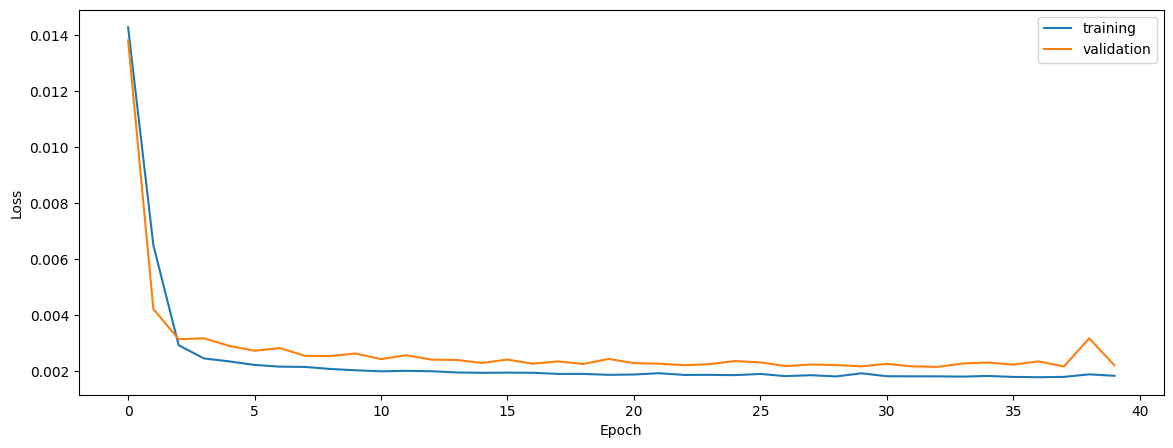

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


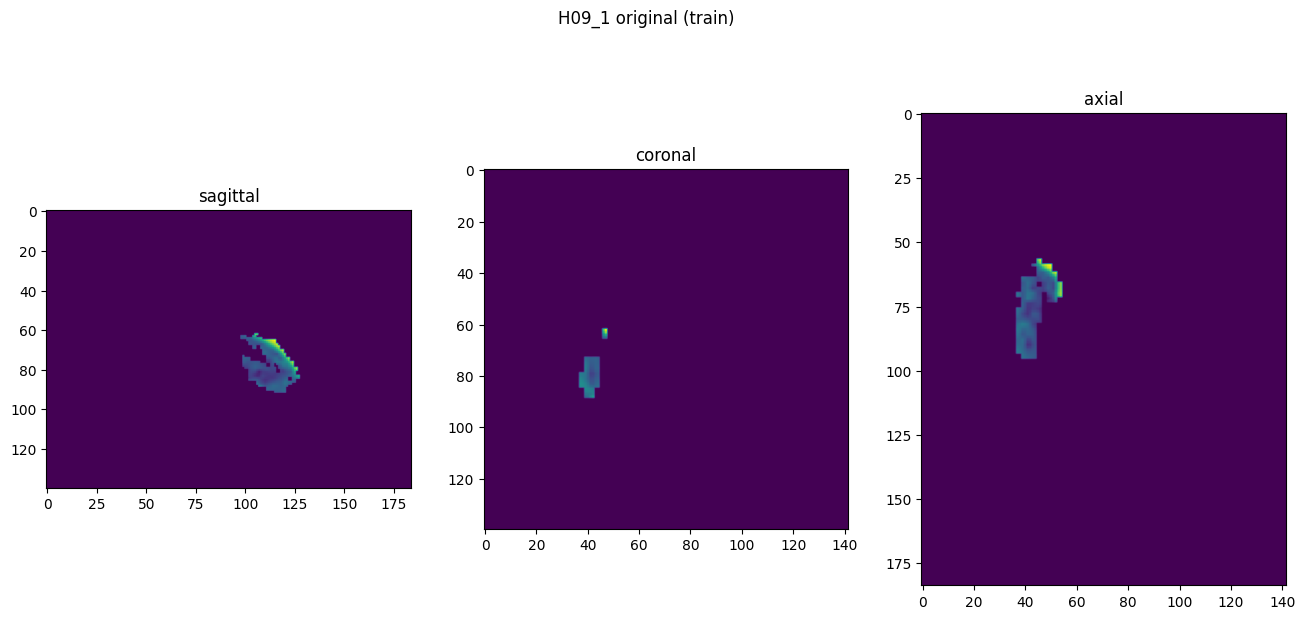

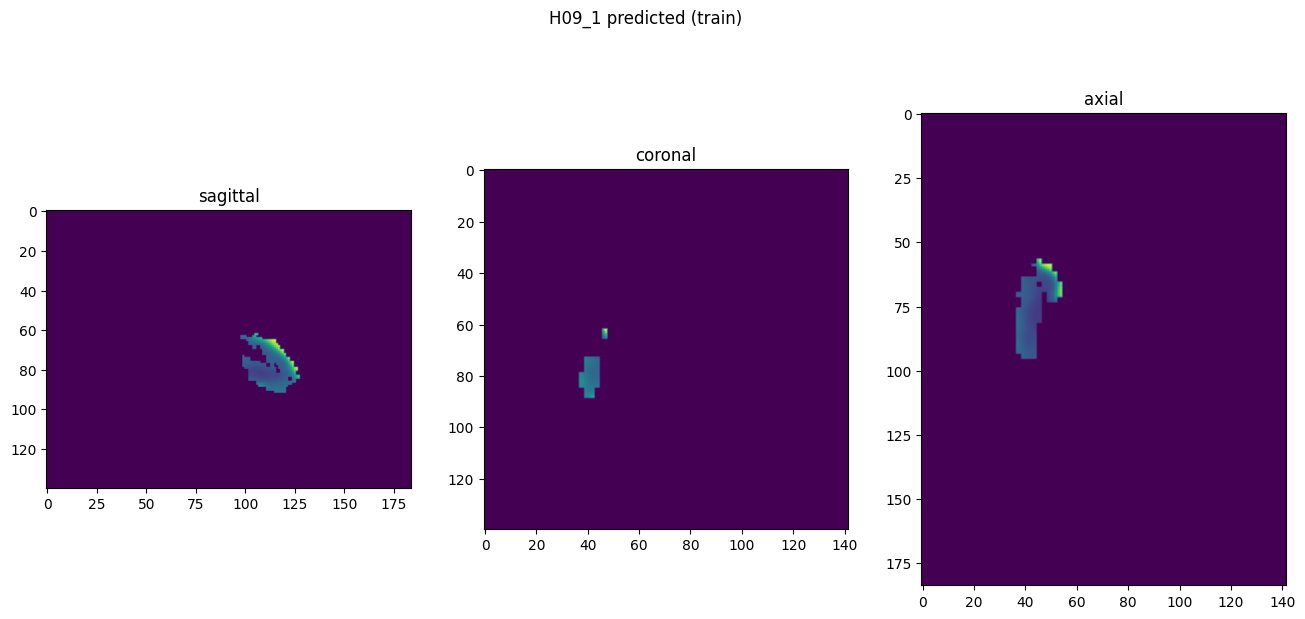

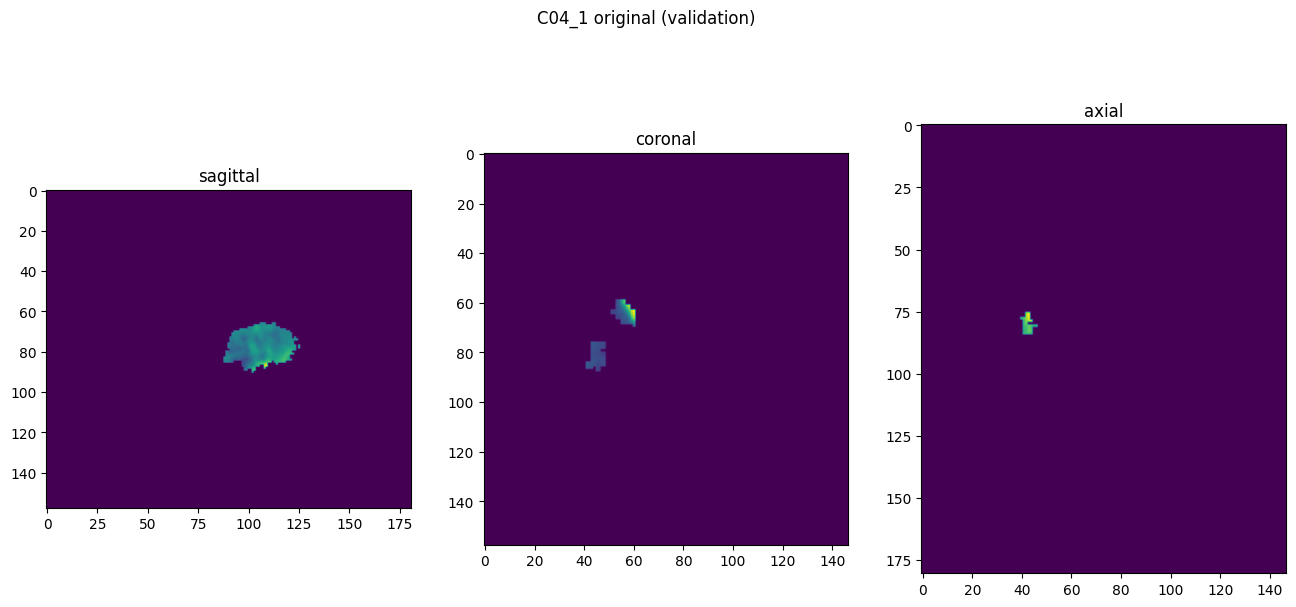

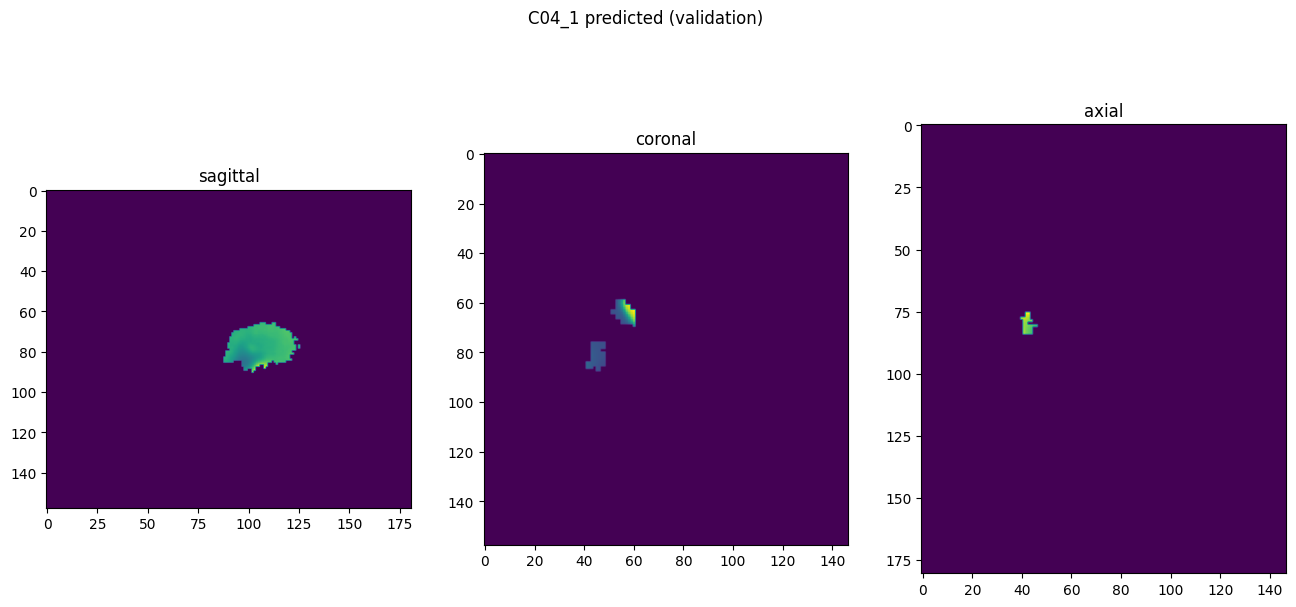

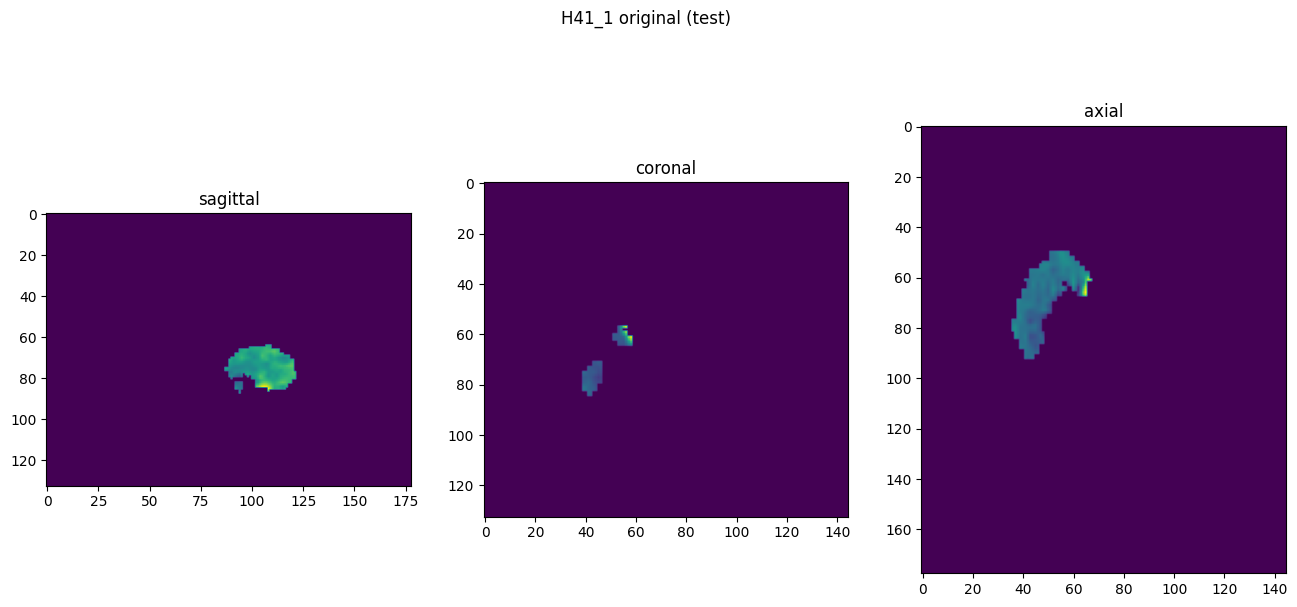

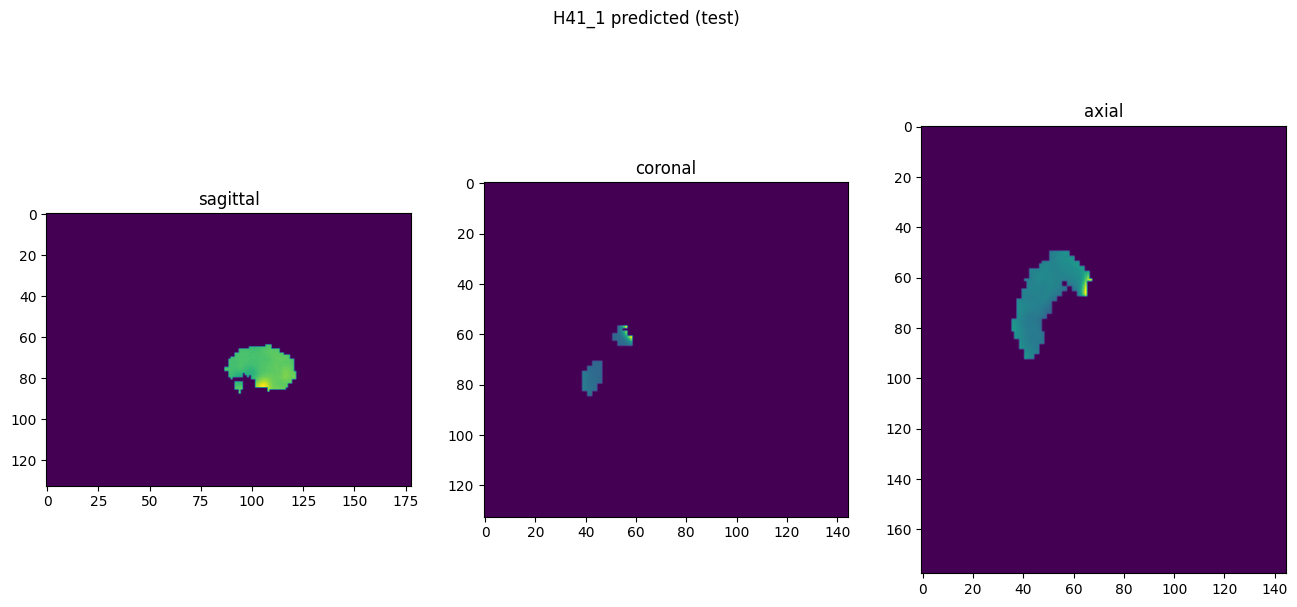

In [10]:
showResults(model, gen, threshold=None, background=False)